In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
import os
print(torch.__version__)

2.5.1


In [13]:
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.mps.is_available():
    device = 'mps' 
else:
    device = 'cpu'

In [14]:
train_dir = "CustomDataSet/data/train/"
test_dir = "CustomDataSet/data/test/" 

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.RandomGrayscale(p=0.1), 
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [16]:
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [17]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

## DataLoaders

In [18]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [19]:
# from model import CustomCNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjust based on input size (128x128 images)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
class CustomCNN2(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
        self._initialize_weights()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [27]:
model_0 = CustomCNN2(num_classes=4) 
model_0.to(device)

CustomCNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [28]:
len(train_data), len(test_data)

(1834, 608)

In [29]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.001, weight_decay=1e-4) 

In [30]:
from trainNN import train
torch.manual_seed(43) 

from timeit import default_timer as Timer 
start_time = Timer()

results = train(
    model=model_0,
    train_dataloader=train_loader,
    test_dataloader=test_loader, 
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=10,
    device=device
)

end_time = Timer() 
print(f"[Info] Total training time: {end_time - start_time: .3f} seconds")

 10%|█████████████████▌                                                                                                                                                              | 1/10 [00:35<05:17, 35.24s/it]

Epoch: 1 | train_loss: 2.1973 | train_acc: 0.3111 | test_loss: 1.3419 | test_acc: 0.3094


 20%|███████████████████████████████████▏                                                                                                                                            | 2/10 [01:10<04:41, 35.15s/it]

Epoch: 2 | train_loss: 1.3424 | train_acc: 0.3525 | test_loss: 1.2890 | test_acc: 0.3531


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 3/10 [01:49<04:17, 36.84s/it]

Epoch: 3 | train_loss: 1.2994 | train_acc: 0.3804 | test_loss: 1.2668 | test_acc: 0.3906


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 4/10 [02:25<03:40, 36.76s/it]

Epoch: 4 | train_loss: 1.2863 | train_acc: 0.3908 | test_loss: 1.2280 | test_acc: 0.4188


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [03:01<03:02, 36.54s/it]

Epoch: 5 | train_loss: 1.2629 | train_acc: 0.4069 | test_loss: 1.1948 | test_acc: 0.4344


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6/10 [03:43<02:32, 38.22s/it]

Epoch: 6 | train_loss: 1.2458 | train_acc: 0.4366 | test_loss: 1.2056 | test_acc: 0.4453


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6/10 [03:48<02:32, 38.05s/it]


KeyboardInterrupt: 

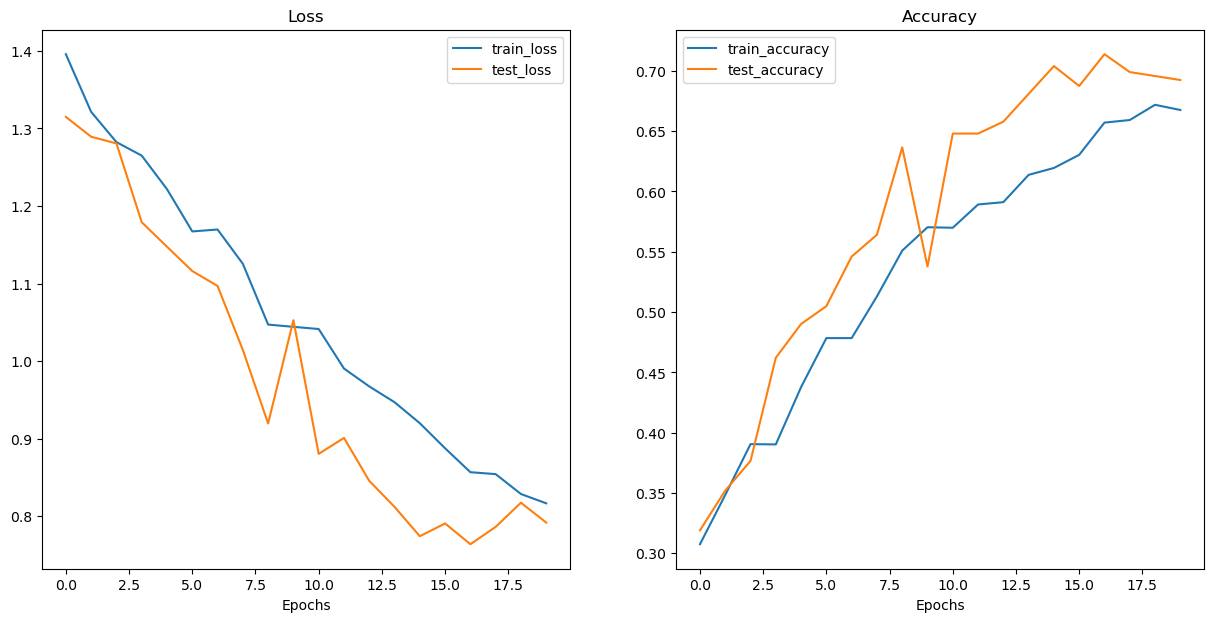

In [13]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [14]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "modelv0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME 
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/modelv0.pth
